# Importing Libraries

In [1]:
# importing required libraries
import os
from os import listdir

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab.patches import cv2_imshow

from skimage.filters import threshold_otsu, sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import clear_border, mark_boundaries
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage import io, color,draw,feature
from skimage import data, filters, measure, morphology

import pandas as pd
import numpy as np




In [2]:
# mounting google drive on colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Converting yolo bounding box coordinates into pixel coordinates
def yolo_to_pascal_voc(x_center, y_center, w, h,  image_w, image_h):
    w = w * image_w
    h = h * image_h
    x1 = int(round(((2 * x_center * image_w) - w)/2))
    y1 = int(round(((2 * y_center * image_h) - h)/2))
    x2 = int(round(x1 + w))
    y2 = int(round(y1 + h))
    return [x1, y1, x2, y2]

**Working with the image coordinates:**

Observe the (x,y) location of the rings present in the displayed image.
Draw bounding boxes on top of these rings.

Display the image with bounding boxes.


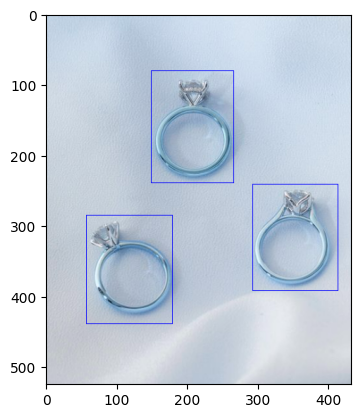

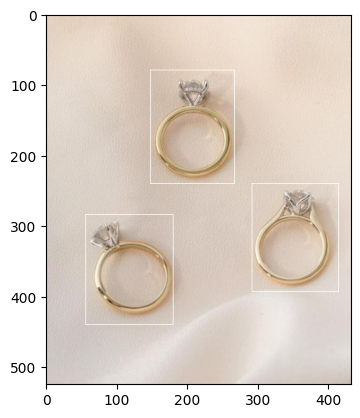

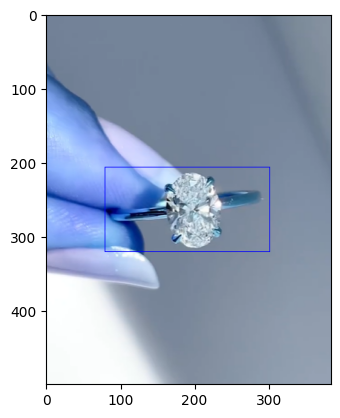

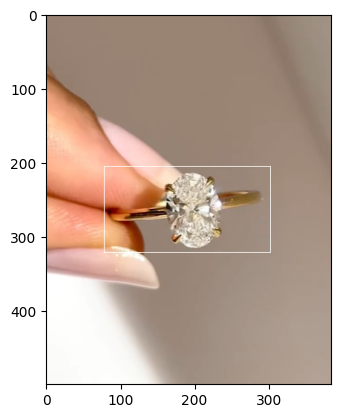

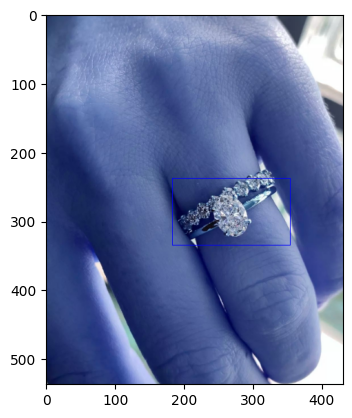

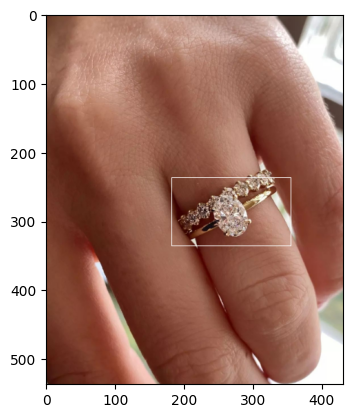

In [4]:

data_path = "/content/drive/MyDrive/Jahnavi Jaddi/Week 1/Ring_sample_data"
df_ground=pd.DataFrame()
df_images=pd.DataFrame(columns=['image_data'])
for images in os.listdir(data_path):
  if (images.endswith(".PNG")):
        img=cv2.imread(data_path+"/"+images)
        img_=img.copy()

        # Storing each image data in dataframe for faster access
        df_images.loc[int(images.replace('s','').replace(".PNG",'')),'image_data']=[img_]
        file=data_path+"/"+images.replace("PNG","txt")
        fl = open(file, 'r')
        data = fl.readlines()
        fl.close()
        img_ip=io.imread(data_path+"/"+images)
        img_rgb=color.rgba2rgb(img_ip)
        for dt in data:
            _, x_center, y_center, w, h = map(float, dt.split(' '))
            image_h, image_w, _ = img_ip.shape
            x1, y1, x2, y2= yolo_to_pascal_voc(x_center, y_center, w, h,  image_w, image_h)
            rr, cc = draw.rectangle_perimeter((y1, x1) ,end=(y2,x2),  shape=( image_h, image_w ))#img_ip.shape)#(l,r)(t,b)  (t, b),(l,r) (t,b),(l,r)   (t,l), (r,b)
            img_ip[rr,cc]=255
            values={'image_name':images,'bbox-0':x1,	'bbox-1':y1,	'bbox-2':x2,	'bbox-3':y2}
            # Storing each image ground truth values from corresponding text files
            df_ground=pd.concat([df_ground,pd.DataFrame(values,index=[0])])
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 1)

        if images in ("s1.PNG","s2.PNG","s3.PNG"):
            plt.imshow(img)
            plt.show()
            plt.imshow(img_ip)
            plt.show()



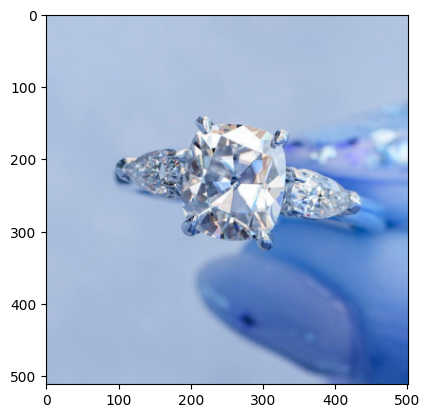

In [5]:
plt.imshow(df_images.iloc[20]['image_data'][0])
plt.show()

In [6]:
df_images.iloc[20]['image_data'][0].shape

(512, 501, 3)

In [7]:
def images_processing(img,properties,df_prop_sub):
  # converting all the images to gray image
  img_gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  img_blur=cv2.GaussianBlur(img_gray, (5,5), 0)

  ## Creating thresh image
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
  img_closed=cv2.morphologyEx(img_blur, cv2.MORPH_CLOSE, kernel)
  img_thresh=cv2.threshold(img_closed, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]


  # Iterating through each image with its ground truth coordinates and prediction coordinates to calculate IOU


  img_fel = felzenszwalb(img_thresh, scale=1000, sigma=0.9, min_size=30).astype(np.uint8)
  # Extracting regions from felzenszwalb
  df_prop_sub=pd.DataFrame(regionprops_table(img_fel,properties=properties))
  df_prop_sub, mask_w =regionprops_calculation(df_prop_sub,img)

  return df_prop_sub, mask_w

In [8]:
# Extracting required regions following the conditions
def regionprops_calculation(df_prop,img_gray):
  df_prop['area_ratio']=df_prop['area_bbox']/(img_gray.shape[0]*img_gray.shape[1])
  df_prop['area_percent']=df_prop['area_ratio']*100
  df_prop=df_prop[(df_prop['area_percent']>5) & (df_prop['area_percent']<=95)]

  mask= np.zeros_like(img_gray)
  mask_w=np.zeros_like(img_gray)
  img_=img_gray.copy()
  for ind in range(len(df_prop)):
    if df_prop.iloc[ind]['bbox-2']<img_gray.shape[1] and df_prop.iloc[ind]['bbox-3']<img_gray.shape[0]:
      x1=df_prop.iloc[ind]['bbox-0']
      y1=df_prop.iloc[ind]['bbox-1']
      x2=df_prop.iloc[ind]['bbox-2']
      y2=df_prop.iloc[ind]['bbox-3']
      crop= img[x1:x2,y1:y2]
      crop_processed=histogram_plot(crop)
      mask[x1:x2,y1:y2]  = img_[x1:x2,y1:y2]
      mask_w[x1:x2,y1:y2] =crop_processed
      # mask_w[x1:x2,y1:y2] =255
      out=np.hstack((img_,mask,mask_w))
      plt.imshow(out)
      plt.show()
  return df_prop,mask_w

In [11]:
df_prop=pd.DataFrame()
df_result=pd.DataFrame(columns=['result_image','coordinates'])
properties=['label','area','area_bbox','bbox','centroid','coords','eccentricity','major_axis_length', 'minor_axis_length','area_filled']
for image_num in df_images.index.values:
  img=df_images.loc[image_num]['image_data'][0]
  df_prop_sub,mask_w = images_processing(img,properties,df_prop)
  df_prop_sub['image_name']='s'+str(image_num)+'.PNG'
  df_prop =pd.concat([df_prop,df_prop_sub])
  # masked_img= mask_w
  masked_img= img*mask_w
  # plt.imshow(img)
  # plt.show()
  gray_image = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)
  _, binary_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)
  edged = cv2.Canny(binary_image, 30, 200)
  contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  image_coordinates = []
  for contour in contours:
      x, y, w, h = cv2.boundingRect(contour)
      image_coordinates.append((x, y, w+x, h+y))
  concatenated=np.hstack([img, masked_img])
  df_result.loc[image_num,'result_image']=[concatenated]
  df_result.loc[image_num,'coordinates']=[image_coordinates]



Output hidden; open in https://colab.research.google.com to view.

**EVALUATION METRICS**

In [12]:
def get_iou(ground_truth, pred):
    # coordinates of the area of intersection.
    ix1 = np.maximum(ground_truth[0], pred[0])
    iy1 = np.maximum(ground_truth[1], pred[1])
    ix2 = np.minimum(ground_truth[2], pred[2])
    iy2 = np.minimum(ground_truth[3], pred[3])

    # Intersection height and width.
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))

    area_of_intersection = i_height * i_width

    # Ground Truth dimensions.
    gt_height = ground_truth[3] - ground_truth[1] + 1
    gt_width = ground_truth[2] - ground_truth[0] + 1

    # Prediction dimensions.
    pd_height = pred[3] - pred[1] + 1
    pd_width = pred[2] - pred[0] + 1

    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection

    iou = area_of_intersection / area_of_union

    return iou

In [13]:
# Precision and recall calculation
def precision_recall_calculation(pred_ord,ground_truths,threshold=0.5):
  tp,fp,fn=0,0,0
  try:
    for ind_g in ground_truths.index:
      max_iou = 0     # default max_iou
      for ind_p in pred_ord.index:
        x1,y1,x2,y2=pred_ord.loc[ind_p]['bbox-0'],pred_ord.loc[ind_p]['bbox-1'],pred_ord.loc[ind_p]['bbox-2'],pred_ord.loc[ind_p]['bbox-3']
        iou = get_iou(ground_truths.loc[ind], [x1,y1,x2,y2]) # calculating IOU values from prediction & ground truth points
        if iou >= max_iou:
            max_iou = iou
      if max_iou>=threshold:
        tp+=1  # increment tp when iou >= threshold
      else:
        fn+=1 # increment when iou < threshold

    for ind_p in pred_ord.index:
      x1,y1,x2,y2=pred_ord.loc[ind_p]['bbox-0'],pred_ord.loc[ind_p]['bbox-1'],pred_ord.loc[ind_p]['bbox-2'],pred_ord.loc[ind_p]['bbox-3']
      max_iou = 0
      for ind_g in ground_truths.index:
        iou = get_iou(ground_truths.loc[ind], [x1,y1,x2,y2])
        if iou >= max_iou:
            max_iou = iou
      if max_iou<threshold:
        fp+=1   # increment when iou < threshold

    precision = tp/(tp+fp)
    recall=tp/(tp+fn)
    return tp,fp,fn,precision,recall
  except:
    return tp,fp,fn,0,0



In [54]:
# Iterating through each image with its ground truth coordinates and prediction coordinates to
# calculate IOU

final_result=pd.DataFrame(columns=['image_num','image_name','pred_box','gt_box','iou'])
df_metrics=pd.DataFrame()
cols=['image_num','tp','fp','fn','precision','recall','ground_truth_count','predicted_count']
for image_num in df_result.index:
  pred_ord=pd.DataFrame(i for i in df_result.loc[image_num]['coordinates'][0])
  pred_ord.rename(columns={0:'bbox-0',1:'bbox-1',2:'bbox-2',3:'bbox-3'},inplace=True)
  img_ip=df_images.loc[image_num,'image_data'][0]
  ground_truths=df_ground[df_ground['image_name']=='s'+str(image_num)+'.PNG'][['bbox-0','bbox-1','bbox-2','bbox-3']]
  index = pd.Index([i+1 for i in range(len(ground_truths))])
  ground_truths = ground_truths.set_index(index)

  for ind in pred_ord.index:
    x1,y1,x2,y2=pred_ord.loc[ind]['bbox-0'],pred_ord.loc[ind]['bbox-1'],pred_ord.loc[ind]['bbox-2'],pred_ord.loc[ind]['bbox-3']
    rr, cc = draw.rectangle_perimeter((y1,x1), end=(y2,x2), shape=img_ip.shape)
    img_ip[rr,cc,:]=(255,0,0)
    max_iou = 0
    for ind in ground_truths.index:
        iou = get_iou(ground_truths.loc[ind], [x1,y1,x2,y2])

        if iou >= max_iou:
            max_iou = iou
            final_preds = [(x1,y1,x2,y2)]
            final_gt_box = [ground_truths.loc[ind].values]
    ground_truth_count=len(ground_truths)
    predicted_count=len(pred_ord)
    values={'image_num':image_num,'image_name':'s'+str(image_num)+'.PNG','pred_box':final_preds,'gt_box':final_gt_box
            ,'iou':max_iou,'ground_truth_count':ground_truth_count,'predicted_count':predicted_count}
    final_result_sub=pd.DataFrame(values)

    final_result=pd.concat([final_result,final_result_sub])
  tp,fp,fn,precision,recall = precision_recall_calculation(pred_ord,ground_truths)
  ground_truth_count=len(ground_truths)
  predicted_count=len(pred_ord)
  df_metrics.loc[image_num,cols]=['s'+str(image_num)+'.PNG',tp,fp,fn,precision,recall,ground_truth_count,predicted_count]

total_tp = sum(df_metrics['tp'].values)
total_fp = sum(df_metrics['fp'].values)
total_fn = sum(df_metrics['fn'].values)
# total_tp, total_fp, total_fn

p = total_tp/(total_tp + total_fp)
r = total_tp/(total_tp + total_fn)


In [59]:
# df_result.groupby(level=0).count()
# ground_truths
# pred_ord
df_metrics['threshold']=0.5
df_metrics[['image_num','ground_truth_count','threshold','predicted_count','tp','fp','fn','precision','recall']]

# '''
# ,Total Rings,Threshold,No of rings fully segmented,TP,FP,FN,Precision,Recall
# '''


,image_num,ground_truth_count,threshold,predicted_count,tp,fp,fn,precision,recall
20,s20.PNG,1.0,0.5,36.0,1.0,35.0,0.0,0.027778,1.0
1,s1.PNG,3.0,0.5,26.0,3.0,25.0,0.0,0.107143,1.0
50,s50.PNG,2.0,0.5,282.0,0.0,282.0,2.0,0.000000,0.0
41,s41.PNG,1.0,0.5,0.0,0.0,0.0,1.0,0.000000,0.0
37,s37.PNG,1.0,0.5,129.0,1.0,128.0,0.0,0.007752,1.0
...,...,...,...,...,...,...,...,...,...
80,s80.PNG,1.0,0.5,95.0,0.0,95.0,1.0,0.000000,0.0
78,s78.PNG,7.0,0.5,127.0,7.0,126.0,0.0,0.052632,1.0
85,s85.PNG,1.0,0.5,364.0,0.0,364.0,1.0,0.000000,0.0
54,s54.PNG,2.0,0.5,43.0,0.0,43.0,2.0,0.000000,0.0


In [61]:
df_metrics_=df_metrics.copy()
df_metrics_.reset_index(drop=True,inplace=True)
df_metrics_

,image_num,tp,fp,fn,precision,recall,ground_truth_count,predicted_count,threshold
0,s20.PNG,1.0,35.0,0.0,0.027778,1.0,1.0,36.0,0.5
1,s1.PNG,3.0,25.0,0.0,0.107143,1.0,3.0,26.0,0.5
2,s50.PNG,0.0,282.0,2.0,0.000000,0.0,2.0,282.0,0.5
3,s41.PNG,0.0,0.0,1.0,0.000000,0.0,1.0,0.0,0.5
4,s37.PNG,1.0,128.0,0.0,0.007752,1.0,1.0,129.0,0.5
...,...,...,...,...,...,...,...,...,...
92,s80.PNG,0.0,95.0,1.0,0.000000,0.0,1.0,95.0,0.5
93,s78.PNG,7.0,126.0,0.0,0.052632,1.0,7.0,127.0,0.5
94,s85.PNG,0.0,364.0,1.0,0.000000,0.0,1.0,364.0,0.5
95,s54.PNG,0.0,43.0,2.0,0.000000,0.0,2.0,43.0,0.5


In [32]:
pd.set_option('display.max_rows', 50)

In [33]:
df_ground.groupby('image_name')['image_name'].count()


image_name
s1.PNG      3
s10.PNG     1
s100.PNG    1
s11.PNG     1
s12.PNG     1
           ..
s95.PNG     1
s96.PNG     1
s97.PNG     1
s98.PNG     1
s99.PNG     1
Name: image_name, Length: 97, dtype: int64

In [39]:
df_metrics_=df_metrics.copy()
df_metrics_.rename(columns={'image_num':'image_name'},inplace=True)
df_ground_count=df_ground.groupby('image_name')['image_name'].count()
df_metrics_ = df_metrics_.join(df_ground_count,on=['image_name'] , how = 'left', lsuffix='_left', rsuffix='_right')
df_metrics_

,image_name_left,tp,fp,fn,precision,recall,image_name_right
20,s20.PNG,1.0,35.0,0.0,0.027778,1.0,1
1,s1.PNG,3.0,25.0,0.0,0.107143,1.0,3
50,s50.PNG,0.0,282.0,2.0,0.000000,0.0,2
41,s41.PNG,0.0,0.0,1.0,0.000000,0.0,1
37,s37.PNG,1.0,128.0,0.0,0.007752,1.0,1
...,...,...,...,...,...,...,...
80,s80.PNG,0.0,95.0,1.0,0.000000,0.0,1
78,s78.PNG,7.0,126.0,0.0,0.052632,1.0,7
85,s85.PNG,0.0,364.0,1.0,0.000000,0.0,1
54,s54.PNG,0.0,43.0,2.0,0.000000,0.0,2


In [35]:
df_metrics_

,image_num,tp,fp,fn,precision,recall,image_name
20,s20.PNG,1.0,35.0,0.0,0.027778,1.0,NaN
1,s1.PNG,3.0,25.0,0.0,0.107143,1.0,NaN
50,s50.PNG,0.0,282.0,2.0,0.000000,0.0,NaN
41,s41.PNG,0.0,0.0,1.0,0.000000,0.0,NaN
37,s37.PNG,1.0,128.0,0.0,0.007752,1.0,NaN
...,...,...,...,...,...,...,...
80,s80.PNG,0.0,95.0,1.0,0.000000,0.0,NaN
78,s78.PNG,7.0,126.0,0.0,0.052632,1.0,NaN
85,s85.PNG,0.0,364.0,1.0,0.000000,0.0,NaN
54,s54.PNG,0.0,43.0,2.0,0.000000,0.0,NaN


In [16]:
print(len(df_metrics[df_metrics['tp']>=0.5]) ,sum(df_metrics['tp'].values) )
print(len(df_metrics[df_metrics['fp']>=0.5]) ,sum(df_metrics['fp'].values) )
print(len(df_metrics[df_metrics['fn']>=0.5]) ,sum(df_metrics['fn'].values) )

27 39.0
85 9582.0
70 96.0


In [17]:
print(len(df_metrics[df_metrics['tp']>=0.5]) ,sum(df_metrics['tp'].values) )
print(len(df_metrics[df_metrics['fp']>=0.5]) ,sum(df_metrics['fp'].values) )
print(len(df_metrics[df_metrics['fn']>=0.5]) ,sum(df_metrics['fn'].values) )

27 39.0
85 9582.0
70 96.0


In [18]:
print(f"total_tp {0}, total_fp {1}, total_fn {2},p {3}, r {4} ".format(total_tp, total_fp, total_fn,p,r))

total_tp 0, total_fp 1, total_fn 2,p 3, r 4 


In [19]:
def histogram_plot(crop):
  # tuple to select colors of each channel line
  colors = ("red", "green", "blue")

  # create the histogram plot, with three lines, one for each color
  # fig=plt.figure(figsize=(12,5))
  # ax1=fig.add_subplot(141)
  # ax1.imshow(crop)
  crop_rgb= crop.copy() #color.rgba2rgb(crop)

  # ax2=fig.add_subplot(142)
  # for channel_id, color_ in enumerate(colors):
  #     histogram, bin_edges = np.histogram(
  #         crop[:, :, channel_id], bins=256, range=(0, 256)
  #     )
  #     ax2.plot(bin_edges[0:-1], histogram, color=color_)

  # ax2.set_title("Color Histogram")
  # ax2.set_xlabel("Color value")
  # ax2.set_ylabel("Pixel count")
  ## ax3=fig.add_subplot(143)

  # img_fel = felzenszwalb(img_thresh, scale=1000, sigma=0.9, min_size=30).astype(np.uint8)
  # ax3.imshow(mark_boundaries(crop_rgb,img_fel))


  edges = feature.canny(color.rgb2gray(crop_rgb))
  # ax4=fig.add_subplot(144)
  # ax4.imshow(edges)
  # fig1=plt.figure()
  # ax1=fig1.add_subplot(141)
  img_closed=morphology.area_closing(edges, 32, connectivity=1)
  img_dilated=morphology.binary_dilation(img_closed)
  img_dilated=morphology.binary_dilation(img_dilated)
  img_close=morphology.diameter_closing(img_dilated, 3, connectivity=1)

  img_close[img_close == 255.0] = 1.0
  mask2 = np.stack((img_close,)*3, axis=-1)

  blended2=crop_rgb*mask2

  # ax1.imshow(blended2)

  # ax22=fig1.add_subplot(142)

  imgg=morphology.binary_closing(img_close)

  imgg = np.stack((imgg,)*3, axis=-1)
  imgg=crop_rgb*imgg
  # ax22.imshow(imgg)

  # contours = measure.find_contours(img_closed,0.8) #fully_connected

  # plt.show()

  # hist_plot(imgg)
  return imgg

**Exercise 1**

#Exercise 1

In [ ]:
img=io.imread(data_path+"/"+"s1.PNG")

img_rgb= color.rgba2rgb(img)

img_gray= color.rgb2gray(img_rgb)
threshold = filters.threshold_otsu(img_gray)
mask = img_gray > threshold
mask_ = morphology.remove_small_objects(mask, 50)
mask_ = morphology.remove_small_holes(mask_, 50)
print(mask.shape)

labels = measure.label(mask)

res1 = felzenszwalb(img_rgb, scale=100)
res2 = felzenszwalb(img_rgb, scale=500)
res3 = felzenszwalb(img_rgb, scale=1000)

# canny edge detection
edges = cv2.Canny(img,100,200)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax1.imshow(mark_boundaries(img_rgb, res1)); ax1.set_xlabel("With k=100")
ax2.imshow(mark_boundaries(img_rgb, res2)); ax2.set_xlabel("With k=500")
ax3.imshow(mark_boundaries(img_rgb, res3)); ax3.set_xlabel("With k=1000")

ax4.imshow(edges,cmap = 'gray'); ax4.set_xlabel("Canny edges")

ax5.imshow(mask_,cmap = 'gray'); ax5.set_xlabel("Mask plot using threshold")

fig.subplots_adjust(hspace=0.4)
fig.suptitle("Plotting the boundaries")


In [ ]:

label_image = label(res3)
properties=['label','area','area_bbox','bbox','centroid','coords','eccentricity','major_axis_length', 'minor_axis_length','area_filled']
df_prop = pd.DataFrame(regionprops_table(res3,properties=properties))
df_prop['area_ratio']=df_prop['area_bbox']/(img_gray.shape[0]*img_gray.shape[1])
df_prop['area_percent']=df_prop['area_ratio']*100


In [ ]:
df_prop=df_prop[df_prop['area_percent']>5]
fig=plt.figure(figsize=(12,5))
mask= np.zeros_like(img_rgb)
img_=img_rgb.copy()
for ind in range(len(df_prop)):
  if df_prop.iloc[ind]['bbox-2']<img_gray.shape[1] and df_prop.iloc[ind]['bbox-3']<img_gray.shape[0]:
    x1=df_prop.iloc[ind]['bbox-0']
    y1=df_prop.iloc[ind]['bbox-1']
    x2=df_prop.iloc[ind]['bbox-2']
    y2=df_prop.iloc[ind]['bbox-3']
    crop= img[x1:x2,y1:y2]
    mask[x1:x2,y1:y2]  = img_[x1:x2,y1:y2]
    # num=int('23{0}'.format(ind))
    ax1=fig.add_subplot(121)
    ax2=fig.add_subplot(122)

    # ax1.imshow(img)
    ax1.imshow(mask)
    out=np.hstack((img_,mask))
    ax2.imshow(out)


plt.show()

In [ ]:
df_prop

In [ ]:
def

In [ ]:
crop1=img[df_prop.iloc[1]['bbox-0']:df_prop.iloc[1]['bbox-2'],df_prop.iloc[1]['bbox-1']:df_prop.iloc[1]['bbox-3']]
crop2=img[df_prop.iloc[2]['bbox-0']:df_prop.iloc[2]['bbox-2'],df_prop.iloc[2]['bbox-1']:df_prop.iloc[2]['bbox-3']]
crop3=img[df_prop.iloc[3]['bbox-0']:df_prop.iloc[3]['bbox-2'],df_prop.iloc[3]['bbox-1']:df_prop.iloc[3]['bbox-3']]


In [ ]:
plt.imshow(crop1)
plt.show()

**Edge Detection:**

1.Apply edge detection on the grayscale image to identify the region of interest i.e., rings in the image using the canny edge detector.

2.Vary the parameters passed to the edge detection and observe the variation in the results.

3.Display the edge detection results


In [ ]:
# Edge Detection

img_blur = cv2.GaussianBlur(img_gray, (1,1), 0)
smoothed_image = filters.gaussian(img_blur, sigma=1)

# Canny Edge Detection
edges = cv2.Canny(image=img, threshold1=100, threshold2=200) # Canny Edge Detection

# Sobel Edge Detection
# sobelx = cv2.Sobel(src=smoothed_image, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
sobel_ski = sobel(img_gray) # Sobel Edge Detection skimage
sobelx = cv2.Sobel(src=smoothed_image, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5)
sobely = cv2.Sobel(src=smoothed_image, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
sobelxy = cv2.Sobel(src=smoothed_image, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Sobel Edge Detection on  X and Y
# Display Sobel Edge Detection Images
fig = plt.figure(figsize=(12,5))
ax1=fig.add_subplot(231)
ax2=fig.add_subplot(232)
ax3=fig.add_subplot(233)
ax4=fig.add_subplot(234)
ax5=fig.add_subplot(235)


ax1.imshow(edges,cmap = 'gray'); ax1.set_title("Canny edge")
ax2.imshow(sobel_ski,cmap = 'gray'); ax2.set_title("Sobel edge skimage")
ax3.imshow(sobelx,cmap = 'gray'); ax3.set_title("Sobel edge on X")
ax4.imshow(sobely,cmap = 'gray'); ax4.set_title("Sobel edge on  Y")
ax5.imshow(sobelxy,cmap = 'gray'); ax4.set_title("Sobel edge on  X and Y")

fig.subplots_adjust(hspace=0.4)
plt.show()




**Image Segmentation**

1. Apply different segmentation algorithms such as Felsenszwalb, Slic, Quickshift, Watershed, etc. from skimage package on the s1.png image.

2. Vary the parameters passed to the segmentation method and observe the variation in the results.

3. Display the segmented image output.

4. Create a mask based on the segments identified and lay it on top of the original image and display the result.


In [ ]:
# Image Segmentation Techniques:

img_fz = felzenszwalb(img, scale=1000)
img_slic = slic(img, n_segments=250, compactness=100, sigma=1,
                     start_label=1)
img_quick = quickshift(img_rgb, kernel_size=3, max_dist=16, ratio=0.5)
gradient = sobel(img_gray)
img_watershed = watershed(gradient, markers=50, compactness=0.001)

fig = plt.figure(figsize=(12,5))
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)
ax3=fig.add_subplot(223)
ax4=fig.add_subplot(224)


ax1.imshow(mark_boundaries(img_rgb, img_fz)); ax1.set_title("felzenszwalb Segmentation")
ax2.imshow(mark_boundaries(img_rgb, img_slic)); ax2.set_title("Slic Segmentation")
ax3.imshow(mark_boundaries(img_rgb, img_quick),cmap = 'gray'); ax3.set_title("Quick Segmentation")
ax4.imshow(mark_boundaries(img_rgb, img_watershed),cmap = 'gray'); ax4.set_title("Watershed Segmentation")
fig.subplots_adjust(hspace=0.4)
plt.show()

**Histogram Analysis**

Observe the RGB values of different ring colors (Silver, Platinum, Gold) and utilize color based conditions to identify rings in images.

The histograms of the images in R, G, B can be plotted to identify range of values


In [ ]:
# tuple to select colors of each channel line
colors = ("red", "green", "blue")

# create the histogram plot, with three lines, one for
# each color
plt.figure()
plt.xlim([0, 256])
for channel_id, color in enumerate(colors):
    histogram, bin_edges = np.histogram(
        crop1[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=color)

plt.title("Color Histogram")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

In [ ]:
def histogram_plot(crop):
  # tuple to select colors of each channel line
  colors = ("red", "green", "blue")

  # create the histogram plot, with three lines, one for
  # each color
  fig=plt.figure(figsize=(12,5))
  ax1=fig.add_subplot(121)
  ax1.imshow(crop)

  ax2=fig.add_subplot(122)
  for channel_id, color in enumerate(colors):
      histogram, bin_edges = np.histogram(
          crop[:, :, channel_id], bins=256, range=(0, 256)
      )
      ax2.plot(bin_edges[0:-1], histogram, color=color)

  ax2.set_title("Color Histogram")
  ax2.set_xlabel("Color value")
  ax2.set_ylabel("Pixel count")

In [ ]:
data_path = "/content/drive/MyDrive/Jahnavi Jaddi/Week 1/Ring_sample_data"
count=1
for images in os.listdir(data_path):
  if (images.endswith(".PNG")):
        # print(images)
        img=io.imread(data_path+"/"+images)
        file=data_path+"/"+images.replace("PNG","txt")
        fl = open(file, 'r')
        data = fl.readlines()
        fl.close()
        dh, dw, _ = img.shape
        for dt in data:

            # Split string to float
            _, x, y, w, h = map(float, dt.split(' '))

            l = int((x - w / 2) * dw)
            r = int((x + w / 2) * dw)
            t = int((y - h / 2) * dh)
            b = int((y + h / 2) * dh)

            if l < 0:
                l = 0
            if r > dw - 1:
                r = dw - 1
            if t < 0:
                t = 0
            if b > dh - 1:
                b = dh - 1

            cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)
            if images in ("s32.PNG","s13.PNG","s49.PNG"):
              crop=img[t:b,l:r]
              histogram_plot(crop)



**Image cropping:**
Crop/Cut the image regions containing the rings and save them into three separate variables.

Hint : Numpy based array operations could be utilized along with skimage library.
